Import

In [1]:
# Import
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

Data process

In [2]:
# Read data in
# Note that there are no NANs in these data; '?' is
# used when there is missing information
accepts = pd.read_csv('./RCdata/chefmozaccepts.csv')
cuisine = pd.read_csv('./RCdata/chefmozcuisine.csv')
hours = pd.read_csv('./RCdata/chefmozhours4.csv')
parking = pd.read_csv('./RCdata/chefmozparking.csv')
geo = pd.read_csv('./RCdata/geoplaces2.csv',  encoding='latin-1') 
usercuisine = pd.read_csv('./RCdata/usercuisine.csv')
payment = pd.read_csv('./RCdata/userpayment.csv')
profile = pd.read_csv('./RCdata/userprofile.csv')
rating = pd.read_csv('./RCdata/rating_final.csv')

In [3]:
# Combine data together
# Restaurant
res_all = np.concatenate((accepts.placeID.unique(), cuisine.placeID.unique(), 
                          hours.placeID.unique(), parking.placeID.unique(), geo.placeID.unique()))
res_all = np.sort( np.unique(res_all) ) # All the placeID's

In [4]:
# User
user_all = np.concatenate((usercuisine.userID.unique(), payment.userID.unique(), 
                           profile.userID.unique()))
user_all = np.sort( np.unique(user_all) ) # All the userID's

In [5]:
# Rating
overall_rating = pd.DataFrame( np.zeros((len(res_all),len(user_all)))-1.0, 
                              columns=user_all, index=res_all )
food_rating = overall_rating.copy()
service_rating = overall_rating.copy() 

for r, u, o, f, s in zip(rating.placeID, rating.userID, rating.rating, rating.food_rating, 
                         rating.service_rating):
    overall_rating.loc[r,u] = o
    food_rating.loc[r,u] = f
    service_rating.loc[r,u] = s

In [6]:
# Review
review = pd.DataFrame( np.zeros(overall_rating.shape), columns=user_all, index=res_all)
review[overall_rating >= 0] = 1

In [7]:
# Cusine
# use dummy variables for different cuisine categories of the restaurants
res_cuisine = pd.get_dummies(cuisine,columns=['Rcuisine'])

# remove duplicate restaurant ID's. 
# A restaurant with multiple cuisine categories would have multiple columns equal 1
res_cuisine = res_cuisine.groupby('placeID',as_index=False).sum()

In [8]:
# Parking
res_parking = parking.copy()
res_parking.parking_lot = res_parking.parking_lot.map({'fee':1, 'none':0, 'public':1, 'yes':2,
                                        'street':1, 'valet parking':1, 'validated parking':1})

# remove duplicate restaurant ID's. 
# A restaurant with multiple parking options may have a value > 2
res_parking = res_parking.groupby('placeID',as_index=False).sum()

In [9]:
# Information
res_info = geo[['latitude','longitude','placeID','name','address','city','state']]

In [10]:
# Service
# These features should be relevant for rating prediction since they are about services 
# and price. Especially, 'alcohol','smoking_area', and 'price' relate to 'drink_level', 
# 'smoker', and 'budget' in the user profiles 
res_service_price = geo[['placeID','alcohol','smoking_area','other_services','price']]
# 1 if alcohol is available, 0 otherwise
res_service_price.alcohol = res_service_price.alcohol.map(lambda x: 0 if x == 'No_Alcohol_Served' else 1)
# 1 if there is smoking area, 0 otherwise
res_service_price.smoking_area = res_service_price.smoking_area.map(lambda x: 0 if (x == 'none') | (x == 'not permitted') else 1)
# 1 if other services are available, 0 otherwise
res_service_price.other_services = res_service_price.other_services.map(lambda x: 0 if x == 'none'  else 1)
# map price levels to numbers
res_service_price.price = res_service_price.price.map({'low': 1, 'medium': 2, 'high': 3})

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [11]:
# Environment
# Whether these features are relevant is not so clear
res_environment = geo[['placeID','dress_code','accessibility','Rambience','area']]
# 1 if formal dress is required, 0 otherwise
res_environment.dress_code = res_environment.dress_code.map({'informal':0, 'casual':0, 'formal': 1})
# map accessibility levels to numbers
res_environment.accessibility = res_environment.accessibility.map({'no_accessibility':0, 'partially':1, 'completely': 2})
res_environment.Rambience = res_environment.Rambience.map({'familiar':0, 'quiet': 1})
res_environment.area = res_environment.area.map({'open':0, 'closed':1})

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [12]:
# Combine all information into one data frame
df_res = pd.DataFrame({'placeID': res_all})
df_res = pd.merge(left=df_res, right=res_cuisine, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_parking, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_service_price, how="left", on="placeID")
df_res = pd.merge(left=df_res, right=res_environment, how="left", on="placeID")

print(df_res.shape)

(938, 69)


In [13]:
# The placeID's for the 130 restaurants with ratings
res_rated = res_all[np.sum(review,axis=1) > 0] 

# tells us whether a restaurant-user pair has a rating. 0 means No and 1 means Yes.
R = review.loc[res_rated].values  # shape = (130,138)

Y_service = service_rating.loc[res_rated].values
Y_overall = overall_rating.loc[res_rated].values
Y_food  = food_rating.loc[res_rated].values

In [14]:
# select the indices of "df_res" where a restaurant has ratings
index = np.array([x in res_rated for x in df_res['placeID'].values])
index = np.where(index == True)[0]
# restaurant features for the 130 restaurants with ratings
X = df_res.loc[index, :].reset_index(drop=True)

In [15]:
# Handle the NA
X = X.fillna(0) # fill all NANs with 0
# drop a feature if the entire column are 0
features_to_drop = X.columns.values[np.sum(X,axis=0) == 0] 
X = X.drop(features_to_drop, axis=1)
X = X.drop(['placeID'], axis=1)

In [16]:
# Select several features for consideration
X = X[['parking_lot','alcohol','smoking_area','other_services','price','dress_code','accessibility']]
X['x0'] = 1 # add a bias term for linear regressions

Split Training and Validation

In [17]:
# Split Training and Validation set
num_rating = np.round(np.sum(R,axis=0)) # number of ratings from each user (minimum = 3)

# 25% of the existing ratings will be used as the validation set
# So during the training, they will be flagged 
g = lambda x: int(round(x*0.25)) 
flag = np.array( [g(x) for x in num_rating] )

random.seed(0)
cond = True

while cond:

    R_train = R.copy()

    # loop over each user
    for i in range(R_train.shape[1]):
        # the restaurants that are rated
        index = list( np.where(R_train[:,i] == 1)[0] )  
        # randomly select about 25% of them to be flagged
        index_flag = random.sample(index,flag[i])
        R_train[index_flag,i] = 0  
    
    # make sure in the traning set, each restaurant and each user receives/gives at least 
    # 2 ratings
    if (np.sum(R_train,axis=0).min() > 1) & (np.sum(R_train,axis=1).min() > 1): 
        cond = False
        
R_valid = R - R_train 
# Now "R_train" contains 876 ones, and "R_valid" contains 285 ones ("R" contains 1161 ones)
# The shape of "R", "R_train" and "R_valid" are all (130,138)  
print(R_train.sum())
print(R_valid.sum())

876.0
285.0


Evaluation Metrics

In [18]:
# Evaluation Metrics
# 1. RMSE
# 2. FCP
# FCP
def FCP(Y,Y_pred,R):
    
    # list of true ratings from each user (we only select users with at least two ratings)
    Y_fcp = []  
    Y_pred_fcp = [] # list of predicted ratings from each user 
    n_user = R.shape[1]
    
    for i in range(n_user):
        
        cond = (R.sum(axis=0) >= 2)[i] # there should be at least two ratings from a user
        index = np.where( R[:,i] == 1)[0] # the indices (restaurants) with ratings
    
        if cond:
            
            Y_fcp.append( (Y*R)[:,i][index] )
            Y_pred_fcp.append( (Y_pred*R)[:,i][index] )

        
    n_fcp = len(Y_fcp) # number of users with at least two ratings
    TP = 0. # Total number of pairs
    DP = 0. # number of discordant pairs
    CP = 0. # number of concordant pairs (excluding ties)
    
    for i in range(n_fcp):
        
        num_Y = len(Y_fcp[i])   # number of ratings from a user
        TP += num_Y*(num_Y-1)/2 # number of rating pairs = n*(n+1)/2 

        greater = np.array([])
        greater_pred = np.array([])

        # this loop is to go over all the rating pairs
        for j in range(num_Y-1):
            
            not_equal = Y_fcp[i][j] != Y_fcp[i][j+1:]
            greater = Y_fcp[i][j] > Y_fcp[i][j+1:]
            greater_pred = Y_pred_fcp[i][j] > Y_pred_fcp[i][j+1:]

            # filter the ones that are not ties
            greater = greater[not_equal]
            greater_pred = greater_pred[not_equal]

            DP += (greater != greater_pred).sum()
            CP += (greater == greater_pred).sum()
            
    print("Total number of rating pairs: {}".format(int(TP)))
    print("Total number of discordant pairs: {}".format(int(DP)))
    print("Total number of concordant pairs: {}".format(int(CP)))
    print("Total number of ties: {}".format(int(TP-DP-CP)))
    print("FCP: {}".format(CP/(CP+DP)))

Benchmark

In [19]:
def GetMean(Y,R):

    Y = Y*R
    mean =  (np.sum(Y, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    return mean

In [20]:
Y = Y_overall 
Y_mean = GetMean(Y,R_train) # get the average ratings based on the training set
Y_pred = np.zeros(Y.shape) + Y_mean # prediction 

# RMSE
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.6930171831949701
RMSE of the validation set: 0.828933960093509


In [21]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 395
Total number of concordant pairs: 859
Total number of ties: 1554
FCP: 0.6850079744816587


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 32
Total number of concordant pairs: 39
Total number of ties: 130
FCP: 0.5492957746478874


Visualization

In [22]:
def MakeBoxplot(Y_pred, Y_true, R, title):
    
    data1 = Y_pred[R == 1][Y_true[R == 1] == 0]
    data2 = Y_pred[R == 1][Y_true[R == 1] == 1]
    data3 = Y_pred[R == 1][Y_true[R == 1] == 2]
    data = [data1,data2,data3]

    fig = plt.figure()
    plt.boxplot(data)
    plt.xticks([1, 2, 3],[0,1,2])
    plt.xlabel('True Rating')
    plt.ylabel('Predicted Rating')
    plt.title(title)
    plt.show()


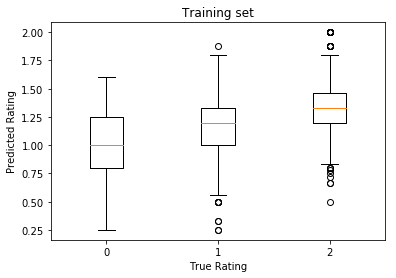

In [23]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')


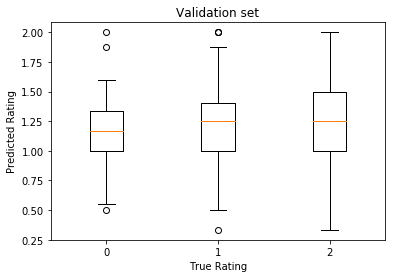

In [24]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')


Content-Based Model 1

In [25]:
# The parameters of the cost function are the weights of all the users, with a shape = 
# (n_user, n_feature), where n_user = 138 = number of users, and n_feature = 8 = number 
# of restaurant features (including the bias term). However, to feed the cost function 
# to SciPy's minimize(), the parameters of the function cannot be a matrix and has to be 
# a 1D vector

def CostFunction(params, X, Y, R, lambd): # lambd is the L2 regularization coefficient
    
    num_user = R.shape[1]
    num_feature = X.shape[1]

    # reshape the parameters to a 2D matrix so we can perform matrix factorization
    Theta = params.reshape(num_user, num_feature)
    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization
    J = J + lambd/2. * np.sum(Theta[:,:-1]**2) 

    return J


def Gradient(params, X, Y, R, lambd):
    
    num_user = R.shape[1]
    num_feature = X.shape[1]

    Theta = params.reshape(num_user, num_feature)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X)

    # regularization
    Theta_grad[:,:-1] = Theta_grad[:,:-1] + lambd*Theta[:,:-1]

    return Theta_grad.reshape(-1)


In [26]:
def MeanNorm(Y,R):
    
    Y_norm = Y*R
    mean =  (np.sum(Y_norm, axis=1)/np.sum((R == 1.0), axis=1)).reshape(Y.shape[0],1) * np.ones(Y.shape)
    Y_norm = (Y_norm - mean)*R

    return Y_norm, mean

In [27]:
# Normalization
Y_norm, Y_mean = MeanNorm(Y,R_train)

n_user = R.shape[1]
n_feature = X.shape[1]
lambd = 64. # L2 regularization; I ran the optimization multiple times with different values 
            # (1, 2, 4, 8...) and 64 results in the best validation FCP
    
Theta = np.random.normal(0,1,(n_user, n_feature)).reshape(-1) # initialize the weights

result = minimize(CostFunction, Theta, jac=Gradient, args=(X, Y_norm, R_train, lambd),
                  options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 109.024339
         Iterations: 206
         Function evaluations: 272
         Gradient evaluations: 272


In [28]:
# Result
# RMSE
Theta_opt = result.x.reshape(n_user, n_feature) # reshape the optimial parameters to a 2D matrix 
Y_pred = np.dot(X, Theta_opt.T) + Y_mean
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.4915099929029173
RMSE of the validation set: 0.6992958828945453


In [29]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 356
Total number of concordant pairs: 898
Total number of ties: 1554
FCP: 0.7161084529505582


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 31
Total number of concordant pairs: 40
Total number of ties: 130
FCP: 0.5633802816901409


Visualization

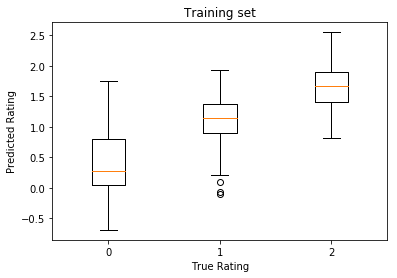

In [30]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')


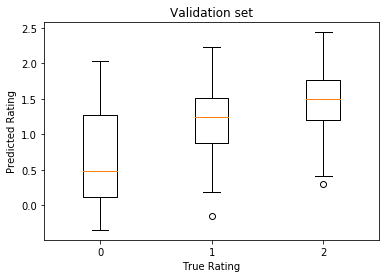

In [31]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')


Content-Based Model 2

In [32]:
# User certain attributes
user_info = profile[['smoker','drink_level','transport','budget']]

# 1 for smokers, 0 otherwise; assume '?' to be non-smokers
user_info.smoker = user_info.smoker.map({'false': 0, 'true': 1, '?': 0})
# map drink levels to numbers
user_info.drink_level = user_info.drink_level.map({'abstemious': 1, 'casual drinker': 2, 'social drinker': 3})
# 1 for car owners, 0 otherwise; assume '?' to be not car owners
user_info.transport = user_info.transport.map({'public':0, 'car owner':1, 'on foot':0, '?':0})
# map budget levels to numbers; assume '?' to be medium
user_info.budget = user_info.budget.map({'medium':2, 'low':1, 'high':3, '?':2})

user_info.head()


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:3643: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


,smoker,drink_level,transport,budget
0,0,1,0,2
1,0,1,0,1
2,0,3,0,1
3,0,1,0,2
4,0,1,0,2


In [33]:
Theta_modifier = pd.DataFrame(np.ones((n_user, n_feature)), columns=X.columns.values) 
Theta_modifier['parking_lot'] = user_info['transport'] # 0 or 1
Theta_modifier['alcohol'] = user_info['drink_level'] # 1, 2 or 3
Theta_modifier['smoking_area'] = user_info['smoker'] # 0 or 1
Theta_modifier['price'] = 1.0/user_info['budget'] # 1 (low), 1/2 (medium) or 1/3 (high)
Theta_modifier = Theta_modifier.values

In [34]:
def CostFunction2(params, X, Y, R, Theta_modifier, lambd):

    num_user = R.shape[1]
    num_feature = X.shape[1]

    # reshape the Theta_modifier to 1-D
    Theta_temp = Theta_modifier.reshape(-1)
    # elements with non-zero values in Theta_modifier are multiplied to the input weights
    Theta_temp[Theta_temp > 0] = Theta_temp[Theta_temp > 0] * params
    
    # reshape the parameters to a 2D matrix so we can perform matrix factorization.
    # Elements with zero values in Theta_modifier always remain 0 in this matrix (for those 
    # users who don't have a car and those who don't smoke)
    Theta = Theta_temp.reshape(num_user, num_feature)
    J = 0.5 * np.sum( (np.dot(X, Theta.T) * R - Y)**2 )

    # regularization
    J = J + lambd/2. * np.sum(Theta[:,:-1]**2) 

    return J


def Gradient2(params, X, Y, R, Theta_modifier, lambd):

    num_user = R.shape[1]
    num_feature = X.shape[1]

    Theta_temp = Theta_modifier.reshape(-1)
    Theta_temp[Theta_temp > 0] = Theta_temp[Theta_temp > 0] * params

    Theta = Theta_temp.reshape(num_user, num_feature)
    Theta_grad = np.dot((np.dot(Theta, X.T) * R.T - Y.T), X) 

    # regularization
    Theta_grad[:,:-1] = Theta_grad[:,:-1] + lambd*Theta[:,:-1]
    Theta_grad = Theta_grad * Theta_modifier

    Theta_grad = Theta_grad[Theta_modifier > 0]
    
    return Theta_grad


In [35]:
lambd = 64. # L2 regularization; I ran the optimization multiple times with different values 
            # (1, 2, 4, 8...) and 64 results in the best validation FCP
    
Theta = np.random.normal(0,1,(n_user, n_feature))[Theta_modifier > 0] # initialize the weights

result = minimize(CostFunction2, Theta, jac=Gradient2, args=(X, Y_norm, R_train, Theta_modifier, 
                  lambd), options={'disp': True, 'maxiter': 500})

Optimization terminated successfully.
         Current function value: 110.032844
         Iterations: 218
         Function evaluations: 259
         Gradient evaluations: 259


In [36]:
# elements with non-zero values in Theta_modifier are multiplied to the optimal weights
Theta_transformer = Theta_modifier.reshape(-1)
Theta_transformer[Theta_transformer > 0] = Theta_transformer[Theta_transformer > 0] * result.x
# reshape the parameters to a 2D matrix 
Theta_opt = Theta_transformer.reshape(n_user, n_feature)

Y_pred = np.dot(X, Theta_opt.T) + Y_mean

# RMSE
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

RMSE of the training set: 0.4959089378645511
RMSE of the validation set: 0.6986709011178627


In [37]:
# FCP
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

Training Set:
Total number of rating pairs: 2808
Total number of discordant pairs: 362
Total number of concordant pairs: 892
Total number of ties: 1554
FCP: 0.7113237639553429


Validation Set:
Total number of rating pairs: 201
Total number of discordant pairs: 31
Total number of concordant pairs: 40
Total number of ties: 130
FCP: 0.5633802816901409


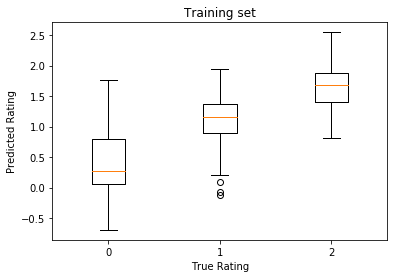

In [38]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')


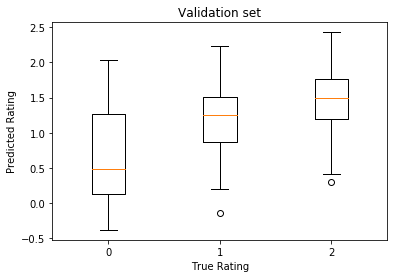

In [39]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')


In [40]:
R_test =  R*(-1) + 1.0 # 1 for those without existing ratings, 0 otherwise

# predicted ratings for the restaurants that each user hasn't visited
Y_final = Y_pred * R_test
Y_final = pd.DataFrame( Y_final, columns=user_all, index=res_rated )
Y_final.head()

,U1001,U1002,U1003,U1004,U1005,U1006,U1007,U1008,U1009,U1010,...,U1129,U1130,U1131,U1132,U1133,U1134,U1135,U1136,U1137,U1138
132560,0.163740,0.604283,0.456770,0.681650,0.354380,0.582535,0.042386,0.409461,0.709452,0.316296,...,0.241337,0.275990,0.497432,0.652353,0.372582,0.296975,-0.880665,0.547155,0.787210,0.834625
132561,0.545511,0.988817,0.811936,0.987384,0.686475,0.928679,0.406147,0.754006,1.017195,0.669804,...,0.000000,0.000000,0.837818,1.005382,0.644856,0.563835,-0.535512,0.911746,1.171390,1.167959
132564,1.128844,1.572150,1.395270,1.570717,1.269808,1.512012,0.989481,1.337339,1.600528,1.253138,...,1.172855,1.148102,1.421152,1.588715,1.228190,1.147169,0.047822,1.495079,1.754724,1.751292
132572,0.801921,1.245227,1.068347,1.243794,0.942885,0.000000,0.000000,1.010416,1.273605,0.885864,...,0.845932,0.821179,1.134477,1.261792,0.943213,0.000000,-0.279101,1.176240,1.427800,1.424369
132583,1.187958,1.629883,1.467686,1.667850,1.353761,1.588747,1.057600,1.415067,1.696657,1.336471,...,1.248762,1.253713,1.490896,1.662201,1.331566,1.263739,0.125245,1.566483,1.812633,1.834625


Content-Based Model 3

In [ ]:
from surprise import SVD 
from surprise.dataset import Reader, Dataset

uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_train[j,i] == 1:
            
            pID.append(res_rated[j])
            uID.append(user_all[i])
            r.append(Y[j,i])


rating_train = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_train = rating_train[['userID','placeID','rating']]

uID = []
pID = []
r = []

for i in range(R.shape[1]):
    for j in range(R.shape[0]):

        if R_valid[j,i] == 1:
            
            pID.append(res_rated[j])
            uID.append(user_all[i])
            r.append(Y[j,i])


rating_valid = pd.DataFrame({'userID':uID, 'placeID':pID, 'rating':r})
rating_valid = rating_valid[['userID','placeID','rating']]

In [ ]:
reader = Reader(rating_scale=(0, 2))
data_train = Dataset.load_from_df(rating_train, reader)
trainset = data_train.build_full_trainset() # use the whole training set 

In [ ]:
model = SVD() # better performance can be done by playing with the parameters
model.train(trainset)

# my data form of ratings: shape=(130,138)
Y_pred = pd.DataFrame( np.zeros((len(res_rated),len(user_all)))-1.0, columns=user_all, index=res_rated )

size_valid = len(rating_valid)
size_train = len(rating_train)
r_pred_valid = np.zeros(size_valid)
r_pred_train = np.zeros(size_train)

# obtain predictions for the validation set
for i in range(size_valid):
    pred = model.predict(rating_valid.userID[i], rating_valid.placeID[i], verbose=False)
    r_pred_valid[i] = pred.est

# fill the predictions into my 'Y_pred' data frame
for r, u, o in zip(rating_valid.placeID, rating_valid.userID, r_pred_valid):
    Y_pred.loc[r,u] = o

# obtain predictions for the training set    
for i in range(size_train):
    pred = model.predict(rating_train.userID[i], rating_train.placeID[i], verbose=False)
    r_pred_train[i] = pred.est

# fill the predictions into my 'Y_pred' data frame    
for r, u, o in zip(rating_train.placeID, rating_train.userID, r_pred_train):
    Y_pred.loc[r,u] = o
    
Y_pred = Y_pred.values    

In [ ]:
print("RMSE of the training set: {}".format(np.sqrt(mean_squared_error(Y[R_train == 1], Y_pred[R_train == 1]))))
print("RMSE of the validation set: {}".format(np.sqrt(mean_squared_error(Y[R_valid == 1], Y_pred[R_valid == 1]))))

In [ ]:
print("Training Set:")
FCP(Y,Y_pred,R_train)
print("\n")
print("Validation Set:")
FCP(Y,Y_pred,R_valid)

In [ ]:
MakeBoxplot(Y_pred, Y, R_train, 'Training set')


In [ ]:
MakeBoxplot(Y_pred, Y, R_valid, 'Validation set')
